In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [533]:
%matplotlib notebook

In [150]:
USA_population = np.array([92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203211926, 226545805, 248709873, 281421906])
year_step = 10

## Построим интерполяцию по методу Ньютона 

In [151]:
koefs = np.zeros(USA_population.size)
tmp = USA_population.copy()
for i in range(koefs.size):
    koefs[i] = tmp[0]
    new_tmp = np.zeros(tmp.size - 1)
    for j in range(new_tmp.size):
        new_tmp[j] = (tmp[j + 1] - tmp[j]) / (year_step * (i + 1))
    tmp = new_tmp.copy()
    
xi = 1910

def population(year):
    res = 0
    for i in range(koefs.size):
        s = koefs[i]
        for j in range(i):
            s *= (year - xi - j * year_step)
        res += s
    return res

<IPython.core.display.Javascript object>


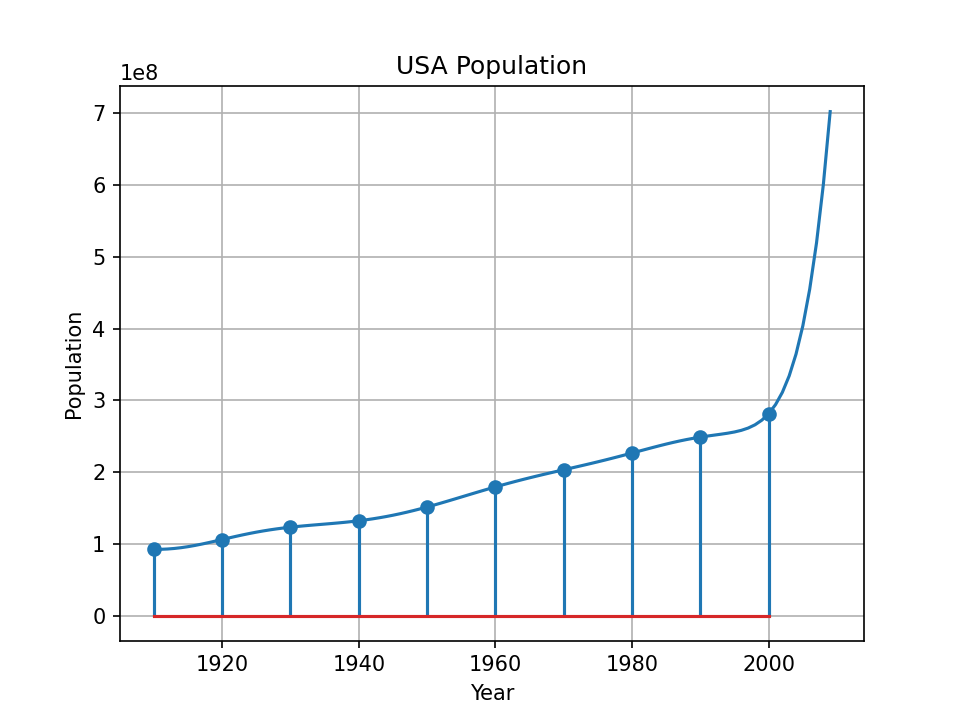

In [152]:
x = np.arange(start = 1910, stop = 2010, step = 1)
y = population(x)

plt.plot(x, y)
plt.stem(np.arange(start = 1910, stop = 2001, step = 10), USA_population)
plt.grid()
plt.title("USA Population")
plt.ylabel("Population")
plt.xlabel("Year")
plt.show()

Модель, очевидно, плохая и совершенно не отражает реальную численность населения США в 2010 году. Впрочем, это ожидаемо, т.к. метод Ньютона на многих точках не годится для экстраполяции за пределы промежутка построения.

## Интерполяция кубическим сплайном

За граничные условия берем = 0 вторых производных на границах известного промежутка

In [521]:
n = USA_population.size
A = np.zeros(shape = [n, n])
f = np.zeros(n)

f[0] = 0
f[n - 1] = 0
for i in range(1, n - 1):
    f[i] = 6 * (USA_population[i - 1] - 2 * USA_population[i] + USA_population[i + 1]) / year_step
    
A[0, 0] = 1
A[n - 1, n - 1] = 1
for i in range(1, n - 1):
    A[i, i - 1] = year_step
    A[i, i] = 4 * year_step
    A[i, i + 1] = year_step

Систему Ac = f решаем методом прогонки

In [522]:
def solve_sys_p(A, f):
    p = np.zeros(f.size - 1)
    r = np.zeros(f.size - 1)
    p[0] = A[0, 1] / A[0, 0]
    r[0] = f[0] / A[0, 0]
    
    for i in range(1, f.size - 1):
        p[i] = A[i, i + 1] / (A[i, i] - A[i, i - 1] * p[i - 1])
        r[i] = (f[i] - A[i, i - 1] * r[i - 1]) / (A[i, i] - A[i, i - 1] * p[i - 1])
        
    x = np.zeros(f.size)
    i = f.size - 1
    x[i] = (f[i] - A[i, i - 1] * r[i - 1]) / (A[i, i] - A[i, i - 1] * p[i - 1])
    i -= 1
    
    while(i > -1):
        x[i] = r[i] - p[i] * x[i + 1]
        i -= 1
        
    return x

In [523]:
c = solve_sys_p(A, f)

In [524]:
a = np.zeros(n)
b = np.zeros(n)
d = np.zeros(n)

a[0] = USA_population[0]
b[0] = USA_population[0] / year_step + c[0] / 3 * year_step
d[0] = c[0] / year_step
for i in range(1, n):
    a[i] = USA_population[i]
    b[i] = (USA_population[i] - USA_population[i - 1]) / year_step + (2 * c[i] + c[i - 1]) / 6 * year_step
    d[i] = (c[i] - c[i - 1]) / year_step

In [525]:
import math

def population(year):
    i = math.floor((year - 1900) / year_step)
    year_i = i * 10 + 1910
    return a[i] + b[i] * (year - year_i) + c[i] / 2 * (year - year_i) ** 2 + d[i] / 6 * (year - year_i) ** 3

In [526]:
x = np.arange(start = 1910, stop = 2000, step = 1)
y = np.zeros(x.size)
for i in range(x.size):
    y[i] = population(x[i])

<IPython.core.display.Javascript object>


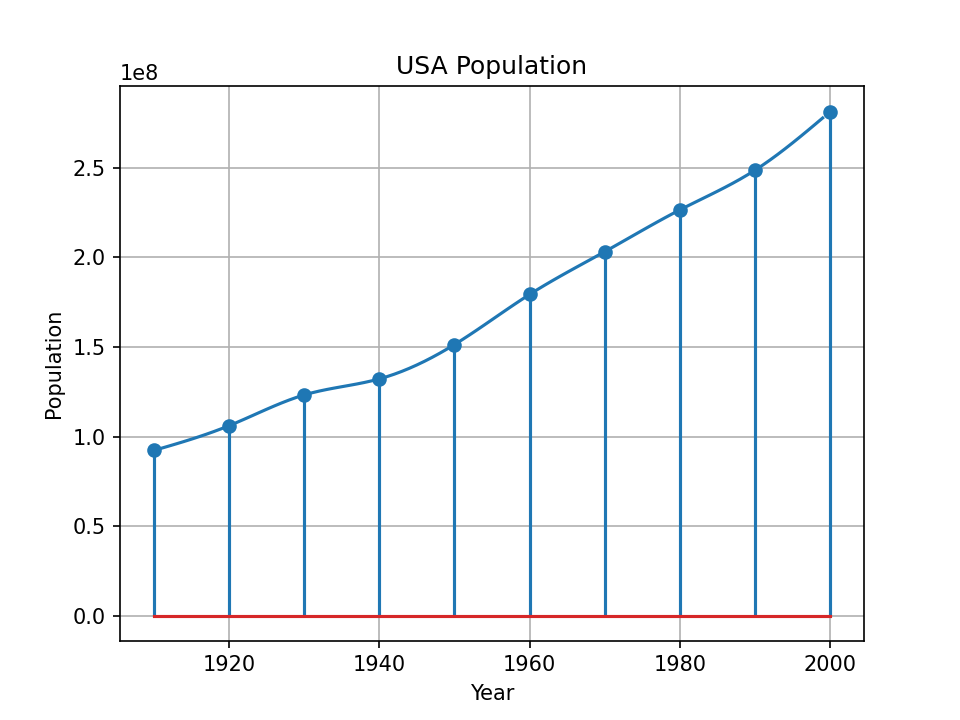

In [532]:
plt.plot(x, y)
plt.stem(np.arange(start = 1910, stop = 2001, step = 10), USA_population)
plt.grid()
plt.title("USA Population")
plt.ylabel("Population")
plt.xlabel("Year")
plt.show()

Для экстраполяции на 2010 год продлим полученную кривую с S'(x) = S'(2000) и S"(x) = S"'(x) = 0 до 2010 года.

In [543]:
a_new = np.zeros(a.size + 2)
b_new = np.zeros(b.size + 2)
c_new = np.zeros(c.size + 2)
d_new = np.zeros(d.size + 2)
n = a.size

for i in range(n):
    a_new[i] = a[i]
    b_new[i] = b[i]
    c_new[i] = c[i]
    d_new[i] = d[i]

d_new[n] = d_new[n - 1]
c_new[n] = c_new[n - 1] + d_new[n] * year_step
b_new[n] = b_new[n - 1] + c_new[n] * year_step + d_new[n - 1] * year_step / 2
a_new[n] = a_new[n - 1] + b_new[n] * year_step + c_new[n - 1] * year_step / 2 + d_new[n - 1] * year_step / 6
n += 1
d_new[n] = d_new[n - 1]
c_new[n] = c_new[n - 1] + d_new[n] * year_step
b_new[n] = b_new[n - 1] + c_new[n] * year_step + d_new[n - 1] * year_step / 2
a_new[n] = a_new[n - 1] + b_new[n] * year_step + c_new[n - 1] * year_step / 2 + d_new[n - 1] * year_step / 6

a = a_new
b = b_new
c = c_new
d = d_new

<IPython.core.display.Javascript object>


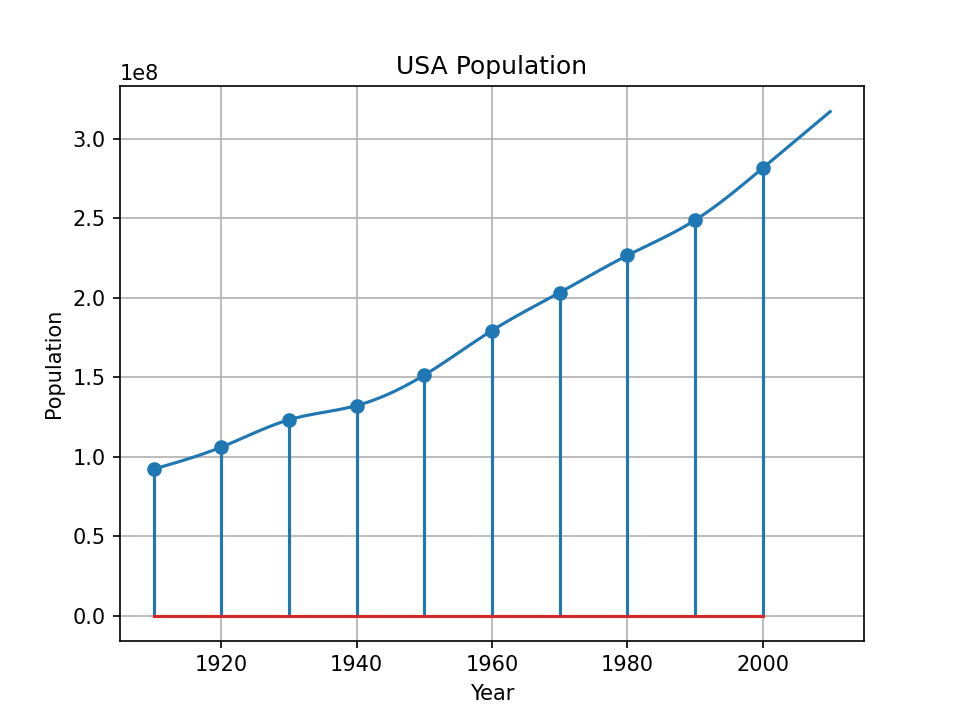

In [544]:
x = np.arange(start = 1910, stop = 2011, step = 1)
y = np.zeros(x.size)
for i in range(x.size):
    y[i] = population(x[i])

plt.plot(x, y)
plt.stem(np.arange(start = 1910, stop = 2001, step = 10), USA_population)
plt.grid()
plt.title("USA Population")
plt.ylabel("Population")
plt.xlabel("Year")
plt.show()

Для 2010 года получаем численность населения равную 317.0623 млн человек. Реальная численность на 2010 год - 308.745538 млн человек. Такую оценку уже можно считать приемлемой.